# Source localization of intracranial stimulation
## Dataset usage demonstration

This notebook will provide a usage demonstration of the dataset. It will cover the necessary steps to load the data, visually explore it, perform source localization and plot the results.

### Imports
First we will import the necessary modules. In order to install these modules, please refer to the [MNE-Python](https://martinos.org/mne/stable/install_mne_python.html) website and follow the instructions. In addition you will need a module that will allow to import our custom function to load the BIDS data. Please run _pip install ipynb_ on your terminal or command prompt once you have activated the environment. If you find any difficulties please open an issue on this repository.

In [1]:
%matplotlib
import mne
import h5py
import numpy as np
import pandas as pd
import os.path as op
import mayavi.mlab as mlab
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from ipynb.fs.full.fx_bids import load_bids

Using matplotlib backend: Qt5Agg


### Definitions
Here we will define the location of the dataset on the hard drive and the subject and session we want to analyze:

In [2]:
dir_bids = '/home/eze/data/artifact_source/share/EEG-source-loc-stim' # base directory of the BIDS dataset
task = 'seegstim' # task name
subj = 'sub-07' # subject id
run = 'run-07' # rund id

## Load data
We will then load the epochs, forward-model, SEEG channel locations, events information and head-to-surface affine transform:

In [3]:
epo = load_bids(dir_bids, subj, task, run) # load epochs
fwd = mne.read_forward_solution(op.join(dir_bids, 'derivatives', 'sourcemodelling', subj, 'fwd', '%s_fwd.fif' % subj)) # load forward solution
seeg_ch_info = pd.read_csv(op.join(dir_bids, 'derivatives', 'epochs', subj, 'ieeg', '%s_task-%s_space-surface_electrodes.tsv' % (subj, task)), sep='\t') # load SEEG channel info 
events = pd.read_csv(op.join(dir_bids, 'derivatives', 'epochs', subj, 'eeg', '%s_task-%s_%s_epochs.tsv' % (subj, task, run)), sep='\t') # load events (contain the stimulating channel name)
trans = h5py.File(op.join(dir_bids, 'derivatives', 'sourcemodelling', subj, 'xfm', '%s_from-head_to-surface.h5' % subj)).get('trans').value # load head-to-surface transform

42 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Reading forward solution from /home/eze/data/artifact_source/share/EEG-source-loc-stim/derivatives/sourcemodelling/sub-07/fwd/sub-07_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (8196 sources, 256 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


## View data
Now, let's see the location of the EEG sensors in 3D. Channels identified as bad will be shown in red. The number of bad channel varies by subject and is mainly caused by the overlap between the positions of the the EEG electrodes and the SEEG electrodes.

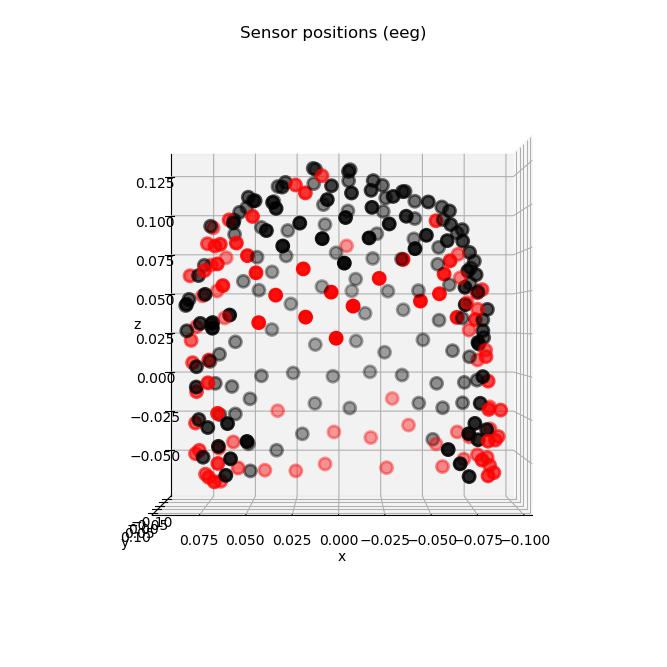

Traceback (most recent call last):
  File "/home/eze/soft/anaconda3/envs/mne3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/home/eze/soft/anaconda3/envs/mne3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/home/eze/soft/mne-python/mne/viz/utils.py", line 1546, in _close_event
    if getattr(fig, 'lasso') is not None:
AttributeError: 'Figure' object has no attribute 'lasso'


In [5]:
epo.plot_sensors(kind='3d') # sensors' positions

Then, let's look at the data by plotting the time courses of the EEG channels (you can interact with the graphic using the arrows and the + and - signs on your keyboard):

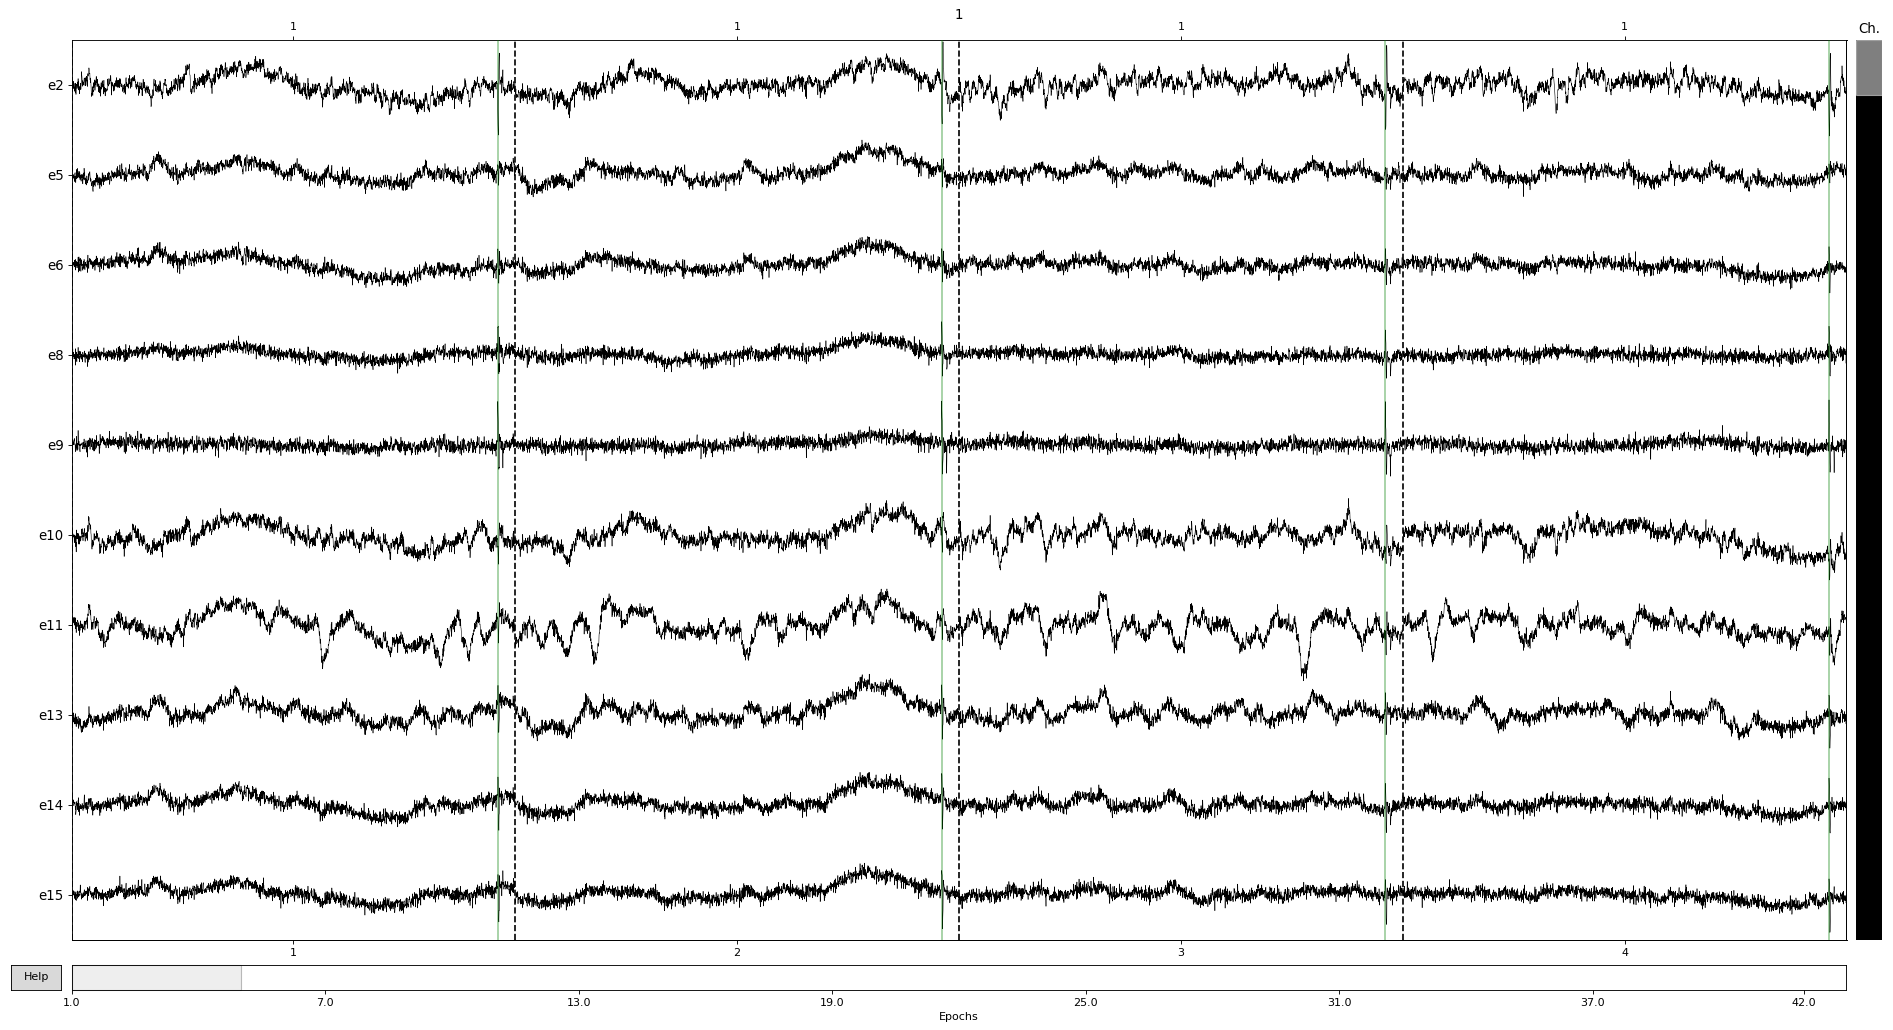

Dropped 0 epochs
Channels marked as bad: ['e1', 'e3', 'e4', 'e7', 'e12', 'e18', 'e19', 'e20', 'e25', 'e26', 'e31', 'e32', 'e33', 'e34', 'e37', 'e38', 'e39', 'e40', 'e42', 'e46', 'e55', 'e56', 'e64', 'e67', 'e68', 'e73', 'e74', 'e75', 'e77', 'e82', 'e83', 'e84', 'e85', 'e86', 'e91', 'e92', 'e93', 'e102', 'e103', 'e111', 'e112', 'e119', 'e120', 'e133', 'e134', 'e135', 'e145', 'e146', 'e156', 'e162', 'e165', 'e167', 'e170', 'e171', 'e172', 'e173', 'e174', 'e180', 'e186', 'e187', 'e192', 'e194', 'e195', 'e196', 'e198', 'e200', 'e202', 'e205', 'e208', 'e209', 'e210', 'e213', 'e214', 'e215', 'e216', 'e217', 'e218', 'e219', 'e223', 'e224', 'e226', 'e228', 'e229', 'e230', 'e233', 'e236', 'e237', 'e246', 'e247', 'e250', 'e251', 'e254', 'e255', 'e256']


In [12]:
epo.plot(n_epochs=4, n_channels=10) # EEG data

## Source localization
Now we are going to go through the necessary steps to perform source localization. First we are going to re-reference the data to the average of all good channels:

In [4]:
epo = epo.set_eeg_reference('average', projection=True)
epo.apply_proj()

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<EpochsArray  |   42 events (all good), -0.25 - 0.01 sec, baseline [-0.3, -0.05], ~171.4 MB, data loaded,
 '1': 42>

Then we are going to compute the covariance between electrodes, which will be used later when creating the inverse operator:

In [5]:
cov = mne.compute_covariance(epo, method='auto', tmin=-0.25, tmax=-0.05)

Computing data rank from raw with rank=None
    Using tolerance 6e-10 (2.2e-16 eps * 162 dim * 1.7e+04  max singular value)
    Estimated rank (eeg): 162
    EEG: rank 162 computed from 162 data channels with 0 projectors
Reducing data rank from 162 -> 162
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 67242
log-likelihood on unseen data (descending order):
   shrunk: -355.135
   empirical: -355.716
   diagonal_fixed: -376.070
selecting best estimator: shrunk
[done]


Afterwards, we are going to compute the inverse operator with a set of _a priori_ defined parameters:

In [ ]:
inv = mne.minimum_norm.make_inverse_operator(epo.info, fwd, cov, loose=1, depth=0.1)

Next, we are going to compute the evoked response and hava a look at it's topography:

In [ ]:
evo = epo.average()

In [ ]:
evo.plot_topomap(np.arange(-0.001, 0.002, 0.0004))

Then we will apply the inverse operator in order to obtain the estimated current values of the sources:

In [ ]:
snr = 1
lambda2 = 1. / snr ** 2
stc = mne.minimum_norm.apply_inverse(evo, inv, method='eLORETA', lambda2=lambda2)

## Plot & Distance
Finally we are going to plot the results and compute the distance between the location of the maximum current value and the coordinates of the stimulating SEEG contacts:

In [ ]:
peak_ix = stc.get_peak(hemi='rh', vert_as_index=True) # get the peak of activation
peak_id = stc.get_peak(hemi='rh')

In [18]:
stim_info = events.trial_type.unique()[0] # get the stimulating contacts' names
stim_ch = stim_info.split()[0]
stim_chs = [stim_ch.split('-')[0], stim_ch.split('-')[0][0] + stim_ch.split('-')[1]] # get monopolar names
stim_coords = seeg_ch_info.loc[seeg_ch_info.name.isin(stim_chs)][['x', 'y', 'z']].values.squeeze() # find the coordinates of the stimulating channels
stim_coords_bip = np.mean(stim_coords, 0) # take the mean between the two contacts

print('Stimulation channels: %s (coordinates: %s)' % (stim_ch, np.round(stim_coords_bip, 2).squeeze()))
print('Stimulation intensity: %s' % stim_info.split()[-1])

Stimulation channels: Q16-17 (coordinates: [ 0.06 -0.02  0.05])
Stimulation intensity: 0.3mA


Let's see the activation time course of the source with the maximum current value:

In [ ]:
plt.plot(stc.times, stc.data[peak_ix[0], :])
plt.xlabel('time (s)')
plt.ylabel('Current')

Now let's see the 3D representation of the brain surface and the locations of the maximum current value and the stimulating contacts:

In [ ]:
surf = [mne.transforms.apply_trans(trans, s['rr']) for s in fwd['src']] # get surface coordinates and apply the head-to-surface transform
tris= [s['tris'] for s in fwd['src']] # get mesh triangle faces

hemi_ix = 0 if '\'' in stim_ch else 1 # determine hemisphere being stimulated
curr_max_coords = surf[hemi_ix][peak_id[0],:]

for s, t in zip(surf, tris):
    mlab.triangular_mesh(s[:,0], s[:,1], s[:,2], t, color=(0.7, 0.7, 0.7), opacity=0.5)

mlab.points3d(*curr_max_coords, scale_factor=0.01, color=(0.0, 0.0, 1.0)) # show the source location in blue
mlab.points3d(*stim_coords_bip, scale_factor=0.01, color=(0.0, 1.0, 0.0)) # show the coordinates of the stimulation site in green
mlab.show()

Finally, let's compute the euclidean distance between them:

In [ ]:
print('Distance between location of the max current value and stimulation coordinates = %.2f mm' % (euclidean(stim_coords_bip, curr_max_coords)*1e3))